C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
Calculating coherence and perplexity: 100%|████████████████████████████████████████████| 11/11 [10:04<00:00, 54.94s/it]


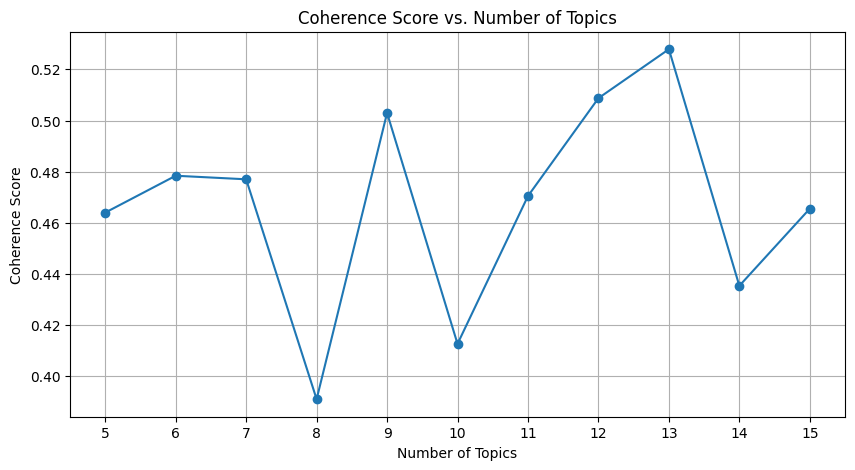

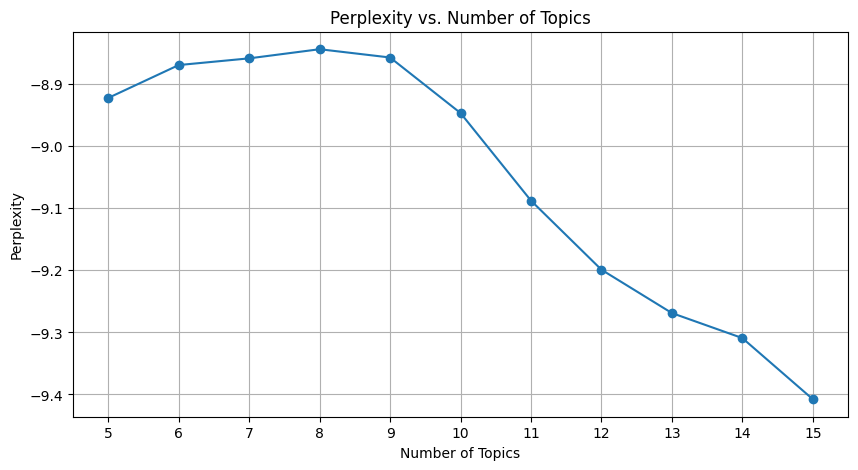

Optimal number of topics based on coherence score: 13


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from gensim.models import CoherenceModel
from tqdm import tqdm
import matplotlib.pyplot as plt

# 엑셀 파일 읽기
file_path = r"C:\Users\user\Desktop\도서관_공모전\최종\book_analysis_final.xlsx"
sheet_name = 3
data = pd.read_excel(file_path, sheet_name=sheet_name)

# 도서명별 키워드 그룹화
grouped_data = data.groupby(data.columns[0]).agg(lambda x: ' '.join(x.dropna().astype(str)))

# 키워드를 리스트로 변환
documents = grouped_data.iloc[:, 0].tolist()

# 텍스트 데이터를 벡터화
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), max_df=0.95, min_df=2)
X = vectorizer.fit_transform(documents)

# Gensim에서 사용할 수 있도록 변환
dictionary = corpora.Dictionary([doc.split() for doc in documents])
corpus_gensim = [dictionary.doc2bow(doc.split()) for doc in documents]

# 적절한 토픽 수 결정 (최적의 토픽 수를 찾기 위한 Coherence Score 및 Perplexity 계산)
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    coherence_values = []
    perplexity_values = []
    for num_topics in tqdm(range(start, limit + 1, step), desc="Calculating coherence and perplexity"):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        coherencemodel = CoherenceModel(model=model, texts=[text.split() for text in texts], dictionary=dictionary, coherence='c_v')
        coherence_values.append((num_topics, coherencemodel.get_coherence()))
        perplexity_values.append((num_topics, model.log_perplexity(corpus)))
    return coherence_values, perplexity_values

# 코히런스 값과 퍼플렉시티 값 계산
coherence_values, perplexity_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_gensim, texts=documents, start=5, limit=15, step=1)

# 그래프 그리기
def plot_values(values, title, ylabel, filename):
    num_topics = [v[0] for v in values]
    scores = [v[1] for v in values]
    plt.figure(figsize=(10, 5))
    plt.plot(num_topics, scores, marker='o')
    plt.title(title)
    plt.xlabel('Number of Topics')
    plt.ylabel(ylabel)
    plt.xticks(num_topics)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

plot_values(coherence_values, 'Coherence Score vs. Number of Topics', 'Coherence Score', 'coherence_score.png')
plot_values(perplexity_values, 'Perplexity vs. Number of Topics', 'Perplexity', 'perplexity.png')

# 최적의 토픽 수 선택
optimal_num_topics = max(coherence_values, key=lambda x: x[1])[0]
print(f"Optimal number of topics based on coherence score: {optimal_num_topics}")

# 최적의 토픽 수를 파일에 저장 (옵션)
with open('optimal_num_topics.txt', 'w') as f:
    f.write(f"{optimal_num_topics}\n")


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# 1. 데이터 불러오기 (sheet_name=3에서 '도서명'과 '키워드' 열을 사용)
file_path = r"C:\Users\user\Desktop\도서관_공모전\최종\book_analysis_final.xlsx"
data = pd.read_excel(file_path, sheet_name=3)

# 2. 도서명으로 그룹화하여 키워드 결합
grouped_data = data.groupby('도서명')['키워드'].apply(lambda x: ' '.join(x)).reset_index()

# 3. 벡터화 (TF-IDF 사용)
vectorizer = TfidfVectorizer(max_df=0.90, min_df=3)  # 파라미터 조정
tfidf_matrix = vectorizer.fit_transform(grouped_data['키워드'])

# 4. LDA 적용
num_topics = 13
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=20, random_state=0)  # 파라미터 조정
lda.fit(tfidf_matrix)

# 5. 각 도서에 대한 토픽 분포를 DataFrame으로 저장
topic_distributions = lda.transform(tfidf_matrix)
topic_distributions_df = pd.DataFrame(topic_distributions, columns=[f"토픽_{i+1}" for i in range(num_topics)])
book_topics = pd.concat([grouped_data['도서명'], topic_distributions_df], axis=1)

# 6. 가장 높은 비율의 토픽을 찾아서 추가
book_topics['가장 높은 토픽'] = topic_distributions_df.idxmax(axis=1).apply(lambda x: int(x.split('_')[1]))

# 7. 각 토픽에 해당하는 상위 키워드 추출
num_top_words = 10
tfidf_feature_names = vectorizer.get_feature_names_out()

def extract_topic_keywords(model, feature_names, num_top_words):
    topic_keywords = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-num_top_words - 1:-1]  # 상위 인덱스
        top_keywords_with_scores = [f"{feature_names[i]} ({topic[i]:.3f})" for i in top_indices]  # 점수 추가
        keywords = " ".join(top_keywords_with_scores)
        topic_keywords.append({'토픽': topic_idx + 1, '키워드': keywords})
    return pd.DataFrame(topic_keywords)

topic_keywords_df = extract_topic_keywords(lda, tfidf_feature_names, num_top_words)

# 8. 결과를 엑셀 파일로 저장 (세 개의 시트로 저장)
output_file_path = r"C:\Users\user\Desktop\도서관_공모전\최종\book_topics_output.xlsx"
with pd.ExcelWriter(output_file_path) as writer:
    book_topics.to_excel(writer, sheet_name='도서별 토픽 분포', index=False)
    topic_keywords_df.to_excel(writer, sheet_name='토픽별 키워드', index=False)

print(f"결과가 '{output_file_path}'에 저장되었습니다.")


결과가 'C:\Users\user\Desktop\도서관_공모전\최종\book_topics_output.xlsx'에 저장되었습니다.


In [3]:
import pandas as pd

# 엑셀 파일 경로 설정
file_path = r'C:\Users\user\Desktop\도서관_공모전\최종\11_토픽모델링\book_topics_output.xlsx'

# 엑셀 파일 읽기
df = pd.read_excel(file_path, sheet_name=0)

# 항목과 가장 높은 토픽 매칭
mapping = {
    1: '정보탐색을 해보자',
    2: '한국의 역사와 이슈에 관심이 있다면',
    3: '만화로 다영한 과학과 역사, 문화를 배워보자',
    4: '감정표현이 서툰 당신을 위해서',
    5: '게임과 서바이벌의 속으로',
    6: '다시 동심속으로',
    7: '인문학의 따뜻함을 느끼고 싶을때',
    8: '미스터리한 범죄 이야기로 스릴을 느끼고 싶을때',
    9: '부자가 되는 첫걸음',
    10: '세계의 어휘를 배워보자',
    11: '진실은 언제나 하나',
    12: '일상의 취재, 생생정보통',
    13: '동물의 이야기에 귀기울여보자'
}

# "가장 높은 토픽" 열의 값 변경
df['가장 높은 토픽'] = df['가장 높은 토픽'].map(mapping)

# 변경된 데이터프레임 저장
output_path = r'C:\Users\user\Desktop\도서관_공모전\최종\11_토픽모델링\book_topics_output_modified.xlsx'
df.to_excel(output_path, index=False)

print(f'파일이 저장되었습니다: {output_path}')


파일이 저장되었습니다: C:\Users\user\Desktop\도서관_공모전\최종\11_토픽모델링\book_topics_output_modified.xlsx
